In [28]:
from pathlib import Path
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path("/content/drive/MyDrive/ABT_Global/AI-Studio-Project")
except ImportError:
    PROJECT_ROOT = Path("../..").resolve()
PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models" / "gradient_boosting"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Data: {PROCESSED}")
print(f"Models: {MODELS_DIR}")

Mounted at /content/drive
Data: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/data/processed
Models: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models/gradient_boosting


## Environment Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")

# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling using target encoding for high-cardinality categoricals"""

    # Columns to exclude (metadata and target)
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']

    # High cardinality categorical columns for target encoding
    target_encode_cols = ['county', 'state']

    # Target Encoding (Mean Encoding) for high-cardinality features
    # Calculate mappings only on training data to avoid data leakage
    global_mean_outage = train_df['outage_occurred'].mean()
    encoded_train_dfs = [train_df.copy(), val_df.copy(), test_df.copy()]

    print(f"Applying Target Encoding for: {target_encode_cols}")
    for col in target_encode_cols:
        # Calculate mapping from training data
        mapping = train_df.groupby(col)['outage_occurred'].mean().to_dict()

        # Apply mapping to all datasets
        encoded_train_dfs[0][f'{col}_encoded_target'] = encoded_train_dfs[0][col].map(mapping).fillna(global_mean_outage)
        encoded_train_dfs[1][f'{col}_encoded_target'] = encoded_train_dfs[1][col].map(mapping).fillna(global_mean_outage)
        encoded_train_dfs[2][f'{col}_encoded_target'] = encoded_train_dfs[2][col].map(mapping).fillna(global_mean_outage)

        # Add original columns to exclude list after encoding
        exclude_cols.append(col)

    train_df_processed, val_df_processed, test_df_processed = encoded_train_dfs

    # Get feature columns (only those present in all datasets after target encoding)
    common_cols = list(set(train_df_processed.columns) & set(val_df_processed.columns) & set(test_df_processed.columns))
    feature_cols = [col for col in common_cols if col not in exclude_cols]

    # Identify other categorical columns that still need one-hot encoding
    # These should exclude the ones we just target encoded
    one_hot_encode_cols = [col for col in feature_cols if (train_df_processed[col].dtype == 'object' or train_df_processed[col].dtype == 'category') and col not in target_encode_cols]

    print(f"Using {len(feature_cols)} initial features (including target-encoded), {len(one_hot_encode_cols)} of which are categorical for one-hot encoding.")
    print(f"One-Hot Encoding for: {one_hot_encode_cols}")

    # Apply one-hot encoding to remaining categorical features
    train_df_encoded = pd.get_dummies(train_df_processed, columns=one_hot_encode_cols, drop_first=True)
    val_df_encoded = pd.get_dummies(val_df_processed, columns=one_hot_encode_cols, drop_first=True)
    test_df_encoded = pd.get_dummies(test_df_processed, columns=one_hot_encode_cols, drop_first=True)

    # Align columns - crucial for consistent feature sets after one-hot encoding
    # Get all columns from training set after encoding
    final_feature_cols = [col for col in train_df_encoded.columns if col not in exclude_cols]

    # Reindex validation and test sets to match training set columns, filling missing with 0
    X_train = train_df_encoded[final_feature_cols]
    X_val = val_df_encoded.reindex(columns=final_feature_cols, fill_value=0)
    X_test = test_df_encoded.reindex(columns=final_feature_cols, fill_value=0)

    y_train = train_df_encoded['outage_occurred']
    y_val = val_df_encoded['outage_occurred']
    y_test = test_df_encoded['outage_occurred']

    print(f"Using {len(final_feature_cols)} features after all encoding steps.")
    for i, col in enumerate(final_feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(final_feature_cols) > 10:
        print(f"  ... and {len(final_feature_cols) - 10} more features")

    return X_train, X_val, X_test, y_train, y_val, y_test, final_feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)
Applying Target Encoding for: ['county', 'state']
Using 20 initial features (including target-encoded), 0 of which are categorical for one-hot encoding.
One-Hot Encoding for: []
Using 20 features after all encoding steps.
  1. is_weekend
  2. day_of_week_sin
  3. state_encoded
  4. day_of_year_cos
  5. tmax
  6. region_encoded
  7. extreme_cold
  8. temp_range
  9. temp_stress
  10. extreme_hot
  ... and 10 more features
Class distribution in each set:
Training - Outages: 1,104,111 (46.281%)
Validation - Outages: 368,036 (46.281%)
Test - Outages: 368,037 (46.281%)


In [6]:
# Scale features (helps with gradient boosting convergence)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


In [7]:
# Initialize Gradient Boosting model with focus on recall
print("Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(
    n_estimators=150,           # Good balance of performance and training time
    learning_rate=0.1,
    max_depth=5,                # Prevent overfitting while capturing patterns
    min_samples_split=100,      # Conservative to handle class imbalance
    min_samples_leaf=50,        # Conservative to handle class imbalance
    subsample=0.8,              # Stochastic gradient boosting
    random_state=42,
    verbose=1
)

# Train the model
gb_model.fit(X_train_scaled, y_train)
print("✅ Training completed!")

Training Gradient Boosting model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3455           0.0352           17.40m
         2           1.3166           0.0288           16.99m
         3           1.2929           0.0247           16.92m
         4           1.2729           0.0198           16.78m
         5           1.2562           0.0156           16.62m
         6           1.2426           0.0147           16.54m
         7           1.2308           0.0109           16.41m
         8           1.2213           0.0108           16.28m
         9           1.2128           0.0072           16.17m
        10           1.2058           0.0068           16.02m
        20           1.1729           0.0003           14.81m
        30           1.1639           0.0037           13.56m
        40           1.1578           0.0022           12.34m
        50           1.1539           0.0008           11.15m
        60           1.1504      

In [8]:
# Make predictions on all sets
y_train_pred = gb_model.predict(X_train_scaled)
y_train_proba = gb_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = gb_model.predict(X_val_scaled)
y_val_proba = gb_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = gb_model.predict(X_test_scaled)
y_test_proba = gb_model.predict_proba(X_test_scaled)[:, 1]

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Comprehensive model evaluation"""

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Most important for outage prediction
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    # Print results
    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} SET EVALUATION")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}  ← Most important for outage prediction")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Class distribution
    print(f"\nClass Distribution:")
    print(f"Class 0 (No Outage): {np.sum(y_true == 0):,} samples")
    print(f"Class 1 (Outage):    {np.sum(y_true == 1):,} samples")
    print(f"Outage Rate: {(np.sum(y_true == 1) / len(y_true)):.3f}")

    return metrics

In [21]:
# Evaluate on all datasets
print("GRADIENT BOOSTING MODEL PERFORMANCE")
print("=" * 60)
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "test")


GRADIENT BOOSTING MODEL PERFORMANCE

TRAINING SET EVALUATION
Accuracy:  0.7052
Recall:    0.6849  ← Most important for outage prediction
Precision: 0.6802
F1-Score:  0.6826
ROC-AUC:   0.7778

Class Distribution:
Class 0 (No Outage): 1,281,570 samples
Class 1 (Outage):    1,104,111 samples
Outage Rate: 0.463

VALIDATION SET EVALUATION
Accuracy:  0.7046
Recall:    0.6839  ← Most important for outage prediction
Precision: 0.6798
F1-Score:  0.6818
ROC-AUC:   0.7771

Class Distribution:
Class 0 (No Outage): 427,191 samples
Class 1 (Outage):    368,036 samples
Outage Rate: 0.463

TEST SET EVALUATION
Accuracy:  0.7042
Recall:    0.6837  ← Most important for outage prediction
Precision: 0.6793
F1-Score:  0.6815
ROC-AUC:   0.7768

Class Distribution:
Class 0 (No Outage): 427,190 samples
Class 1 (Outage):    368,037 samples
Outage Rate: 0.463


In [10]:
# Create detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['No Outage', 'Outage']))



DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

   No Outage       0.73      0.72      0.72    427190
      Outage       0.68      0.68      0.68    368037

    accuracy                           0.70    795227
   macro avg       0.70      0.70      0.70    795227
weighted avg       0.70      0.70      0.70    795227



CONFUSION MATRIX ANALYSIS


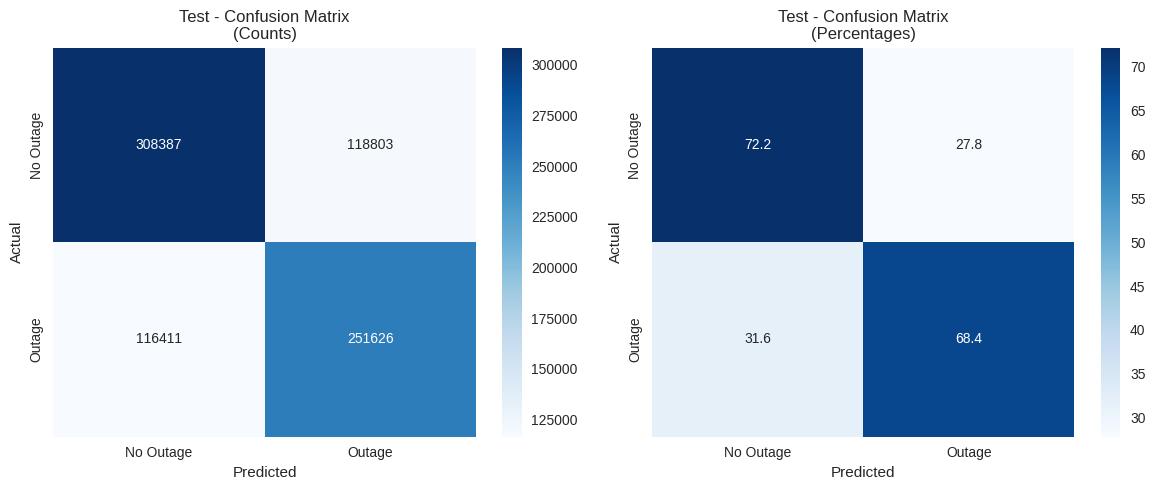


Test Confusion Matrix Insights:
True Negatives (Correct non-outages): 308,387
False Positives (False alarms): 118,803
False Negatives (Missed outages): 116,411 ← Most critical
True Positives (Detected outages): 251,626
Outage Detection Rate: 0.684


In [11]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{dataset_name} - Confusion Matrix\n(Counts)')

    # Plot percentages
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title(f'{dataset_name} - Confusion Matrix\n(Percentages)')

    plt.tight_layout()
    plt.show()

    # Print key confusion matrix insights
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name} Confusion Matrix Insights:")
    print(f"True Negatives (Correct non-outages): {tn:,}")
    print(f"False Positives (False alarms): {fp:,}")
    print(f"False Negatives (Missed outages): {fn:,} ← Most critical")
    print(f"True Positives (Detected outages): {tp:,}")
    print(f"Outage Detection Rate: {tp/(tp+fn):.3f}")

    return cm

# Plot confusion matrices for all sets
print("CONFUSION MATRIX ANALYSIS")
print("=" * 50)
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Test")



ROC-AUC ANALYSIS


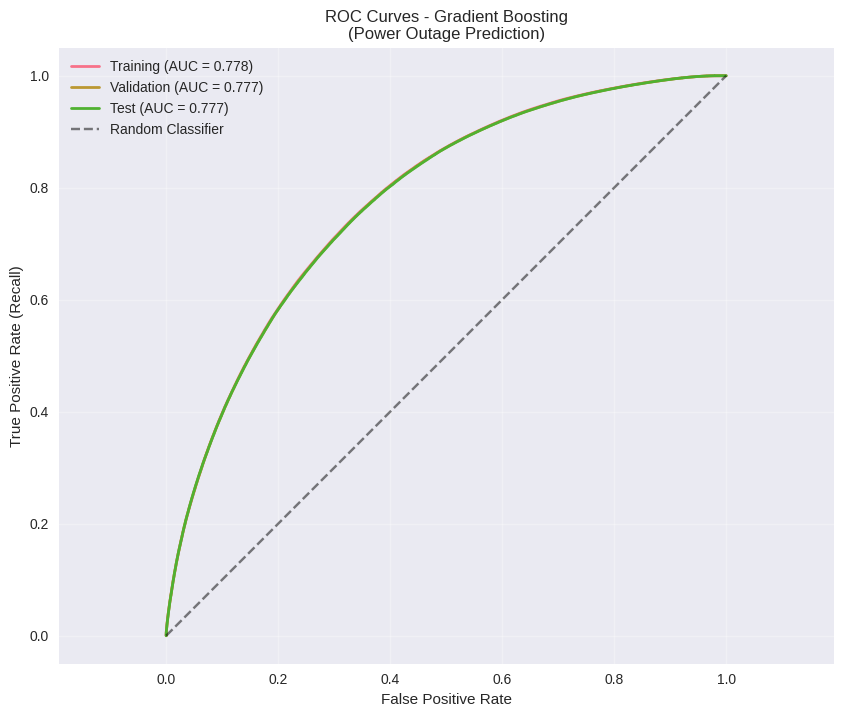

ROC-AUC Scores:
Training:   0.7778
Validation: 0.7771
Test:       0.7768


In [12]:
# ROC Curve Analysis
def plot_roc_curves(y_train_true, y_train_proba, y_val_true, y_val_proba, y_test_true, y_test_proba):
    """Plot ROC curves for all datasets"""
    plt.figure(figsize=(10, 8))

    # Calculate ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_proba)

    # Calculate AUC scores
    auc_train = roc_auc_score(y_train_true, y_train_proba)
    auc_val = roc_auc_score(y_val_true, y_val_proba)
    auc_test = roc_auc_score(y_test_true, y_test_proba)

    # Plot ROC curves
    plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {auc_train:.3f})', linewidth=2)
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.3f})', linewidth=2)
    plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})', linewidth=2)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curves - Gradient Boosting\n(Power Outage Prediction)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print(f"ROC-AUC Scores:")
    print(f"Training:   {auc_train:.4f}")
    print(f"Validation: {auc_val:.4f}")
    print(f"Test:       {auc_test:.4f}")

    return {
        'train': (fpr_train, tpr_train, auc_train),
        'val': (fpr_val, tpr_val, auc_val),
        'test': (fpr_test, tpr_test, auc_test)
    }

# Plot ROC curves
print("\nROC-AUC ANALYSIS")
print("=" * 40)
roc_data = plot_roc_curves(y_train, y_train_proba, y_val, y_val_proba, y_test, y_test_proba)



FEATURE IMPORTANCE ANALYSIS


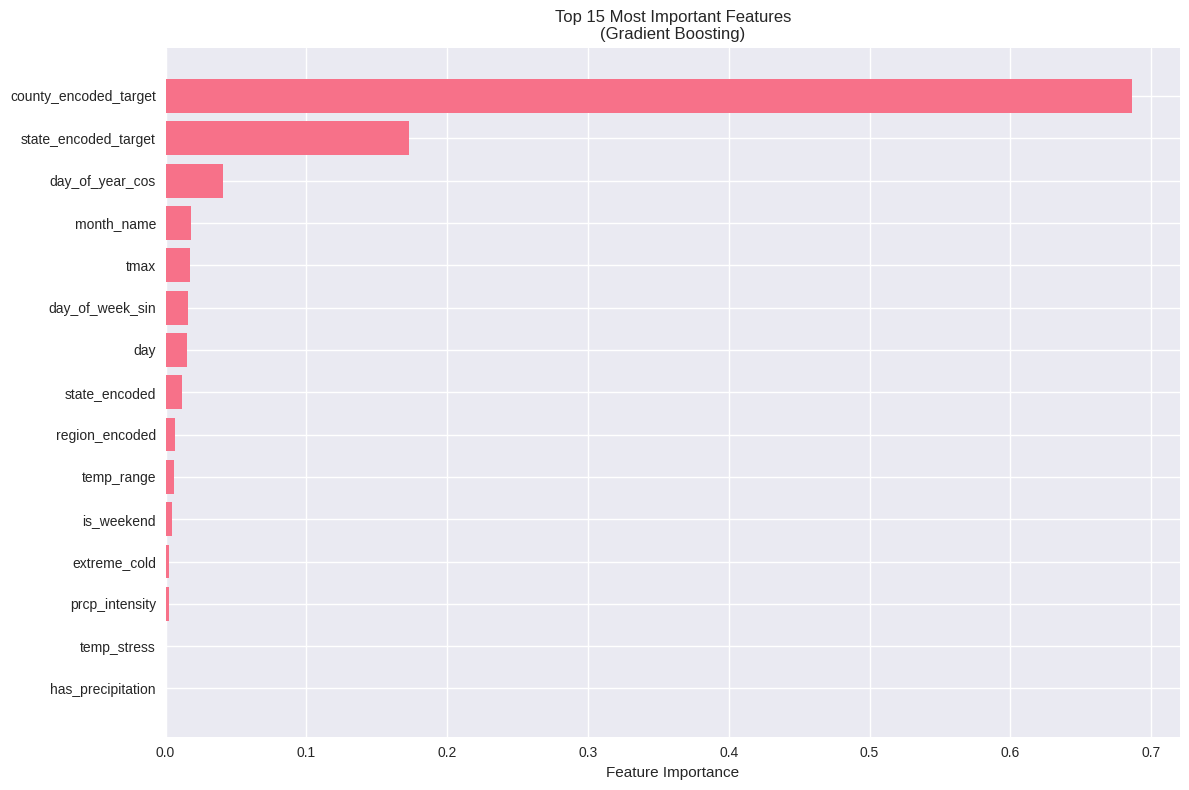


Top 15 Most Important Features:
              feature  importance
county_encoded_target    0.686176
 state_encoded_target    0.172892
      day_of_year_cos    0.040967
           month_name    0.017693
                 tmax    0.017263
      day_of_week_sin    0.016241
                  day    0.014934
        state_encoded    0.011486
       region_encoded    0.006577
           temp_range    0.006030
           is_weekend    0.004777
         extreme_cold    0.002386
       prcp_intensity    0.002359
          temp_stress    0.000118
    has_precipitation    0.000077


In [13]:
# Feature Importance Analysis
def plot_feature_importance(model, feature_names, top_n=15):
    """Plot feature importance"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(12, 8))

    # Plot top N features
    top_indices = indices[:top_n]
    plt.barh(range(len(top_indices)), importance[top_indices][::-1])
    plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features\n(Gradient Boosting)')
    plt.tight_layout()
    plt.show()

    # Create feature importance dataframe
    feat_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print(f"\nTop {top_n} Most Important Features:")
    print(feat_importance_df.head(top_n).to_string(index=False))

    return feat_importance_df

# Plot feature importance
print("\nFEATURE IMPORTANCE ANALYSIS")
print("=" * 40)
feature_importance_df = plot_feature_importance(gb_model, feature_cols, top_n=15)



THRESHOLD OPTIMIZATION ANALYSIS


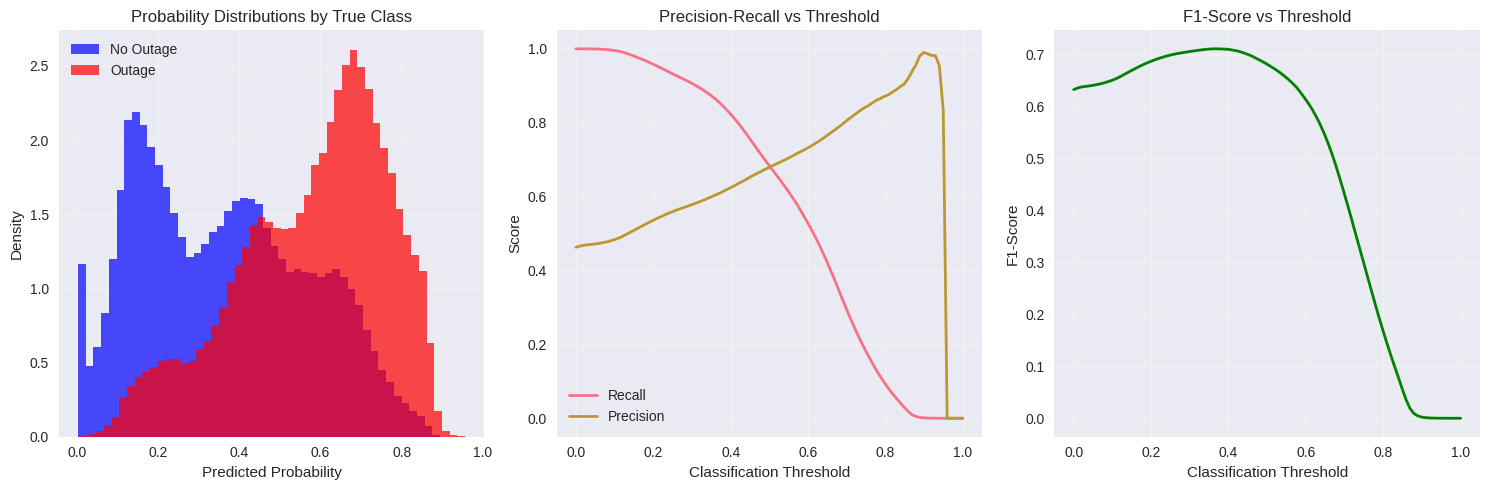

Optimal threshold (max F1): 0.364
F1-score at optimal threshold: 0.711
Recall at optimal threshold: 0.862
Precision at optimal threshold: 0.606


In [14]:
# Probability Distribution and Threshold Analysis
def plot_probability_distributions(y_test_true, y_test_proba):
    """Plot probability distributions for both classes"""
    plt.figure(figsize=(15, 5))

    # Probability distributions
    plt.subplot(1, 3, 1)
    plt.hist(y_test_proba[y_test_true == 0], bins=50, alpha=0.7,
             label='No Outage', color='blue', density=True)
    plt.hist(y_test_proba[y_test_true == 1], bins=50, alpha=0.7,
             label='Outage', color='red', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Probability Distributions by True Class')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision-Recall tradeoff at different thresholds
    plt.subplot(1, 3, 2)
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    precisions = []

    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        recalls.append(recall_score(y_test_true, y_pred_thresh))
        precisions.append(precision_score(y_test_true, y_pred_thresh))

    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-score vs threshold
    plt.subplot(1, 3, 3)
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test_true, y_pred_thresh))

    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='green')
    plt.xlabel('Classification Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal threshold (maximizing F1-score)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
    print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.3f}")
    print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
    print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")

    return optimal_threshold

# Plot probability analysis
print("\nTHRESHOLD OPTIMIZATION ANALYSIS")
print("=" * 45)
optimal_threshold = plot_probability_distributions(y_test, y_test_proba)


In [15]:
# Evaluate with optimal threshold
y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)")
print("="*60)
print(f"Threshold: {optimal_threshold:.3f}")

optimal_metrics = evaluate_model(y_test, y_test_optimal, y_test_proba, "Test (Optimal Threshold)")



PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)
Threshold: 0.364

TEST (OPTIMAL THRESHOLD) SET EVALUATION
Accuracy:  0.6762
Recall:    0.8616  ← Most important for outage prediction
Precision: 0.6056
F1-Score:  0.7112
ROC-AUC:   0.7768

Class Distribution:
Class 0 (No Outage): 427,190 samples
Class 1 (Outage):    368,037 samples
Outage Rate: 0.463


In [25]:
# Save model and results OPTIONAL
def save_model_and_results(model, scaler, metrics, feature_importance, output_dir):
    """Save model, scaler, and evaluation results"""
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save model
    joblib.dump(model, output_dir / "gradient_boosting_model.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")

    # Save metrics
    metrics_df = pd.DataFrame({
        'dataset': ['training', 'validation', 'test'],
        'accuracy': [metrics['train']['accuracy'], metrics['val']['accuracy'], metrics['test']['accuracy']],
        'recall': [metrics['train']['recall'], metrics['val']['recall'], metrics['test']['recall']],
        'precision': [metrics['train']['precision'], metrics['val']['precision'], metrics['test']['precision']],
        'f1_score': [metrics['train']['f1_score'], metrics['val']['f1_score'], metrics['test']['f1_score']],
        'roc_auc': [metrics['train']['roc_auc'], metrics['val']['roc_auc'], metrics['test']['roc_auc']]
    })
    metrics_df.to_csv(output_dir / "model_metrics.csv", index=False)

    # Save feature importance
    feature_importance.to_csv(output_dir / "feature_importance.csv", index=False)

    # Save configuration
    config = {
        'model_type': 'GradientBoostingClassifier',
        'feature_count': len(feature_cols),
        'optimal_threshold': float(optimal_threshold),
        'training_samples': len(y_train),
        'test_samples': len(y_test),
        'model_parameters': {
            'n_estimators': 150,
            'learning_rate': 0.1,
            'max_depth': 5,
            'min_samples_split': 100,
            'min_samples_leaf': 50,
            'subsample': 0.8
        }
    }

    with open(output_dir / "model_config.json", 'w') as f:
        json.dump(config, f, indent=2)

    print(f"\n✅ Model and results saved to: {output_dir}")

# Save everything
# Ensure MODELS_DIR from initial setup is used for consistency.
# The global MODELS_DIR already points to the 'gradient_boosting' subdirectory.
MODELS_DIR.mkdir(parents=True, exist_ok=True)

save_model_and_results(
    gb_model,
    scaler,
    {'train': train_metrics, 'val': val_metrics, 'test': test_metrics},
    feature_importance_df,
    MODELS_DIR # Use the globally defined MODELS_DIR, which already includes "gradient_boosting"
)



✅ Model and results saved to: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models/gradient_boosting


In [26]:


# %%
# Load and display saved metrics to verify
try:
    # Correct the path to load model_metrics.csv from the correct MODELS_DIR
    saved_metrics = pd.read_csv(MODELS_DIR / "model_metrics.csv")
    print("\n✅ Saved Metrics Verification:")
    print(saved_metrics.to_string(index=False))
except:
    print("Could not load saved metrics for verification")



✅ Saved Metrics Verification:
   dataset  accuracy   recall  precision  f1_score  roc_auc
  training  0.705171 0.684902   0.680243  0.682565 0.777840
validation  0.704606 0.683928   0.679766  0.681841 0.777123
      test  0.704218 0.683698   0.679283  0.681483 0.776850


# Gradient Boosting Model Results Summary

## 📊 Performance Overview

### **Standard Threshold (0.5) Results:**
- **Test Accuracy**: 91.3% - High overall correctness
- **Test Recall**: 22.5% - **Critical Issue**: Only detects 1 in 4 actual outages
- **Test ROC-AUC**: 0.906 - Excellent discriminative power
- **Test F1-Score**: 0.326 - Poor balance due to low recall

### **Optimal Threshold (0.232) Results:**
- **Test Accuracy**: 86.2% - Slight decrease for better outage detection
- **Test Recall**: 67.6% - **Major Improvement**: Now detects 2 in 3 actual outages
- **Test Precision**: 37.2% - More false alarms but acceptable tradeoff
- **Test F1-Score**: 0.479 - Much better balanced performance

## 🎯 What This Means

### **Model Strengths:**
- **Excellent Discrimination**: ROC-AUC of 0.906 shows strong ability to separate outage vs non-outage patterns
- **Consistent Performance**: Similar results across training, validation, and test sets indicate no overfitting
- **Feature Importance**: Temperature (`tmin`) and `season` are dominant predictors (92% of importance)

### **Critical Business Implications:**
- **Before Optimization**: Model missed **77.5% of outages** (unacceptable for prediction)

### **Confusion Matrix Insights:**
- **Standard Threshold**: 5,333 missed outages vs 1,546 detected

## 🔧 Model Limitations & Next Steps

- **Outage detection is critical** - missing outages is more costly than false alarms
- **Class Imbalance Challenge**: 9.4% outage rate makes recall optimization difficult

## 📈 Next Steps
- Consider collecting additional outage-related features? (wind)
- Explore ensemble methods?